# Distance Analysis: skin-celldive-ge

> Analyze and visualize cell-to-nearest-endothelial-cell distance distributions for the `skin-celldive-ge` dataset.

In [1]:
import numpy as np
import pandas as pd
import os
import json
import requests
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
import plotly.express as px

from _cde_compute_edges_from_nodes import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# suppress warnings
import warnings
warnings.filterwarnings("ignore")   

In [2]:
basepath = "/u/yashjain/hra-cell-distance-analysis/data"
dataset_dir = "skin-celldive-ge" 
data_filedir = os.path.join("data-processed-nodes-with-harmonized-cell-types", dataset_dir)
output_edge_dir = os.path.join("data-processed-edges", dataset_dir)
figures_output_dir = "generated-figures"

In [3]:
# Function to load your data
def load_data(path, edges=False):
    if edges:
        column_names = ['cell_id', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2']
        data = pd.read_csv(path, header=None, names=column_names)
    else:
        data = pd.read_csv(path)
    return data

In [4]:
# Function to read all files ending with "-nodes.csv" in the `data_filedir` directory into a single DataFrame. 
# Another additional column `Dataset` is added to identify the dataset name which comes from the filename before the `-nodes.csv` suffix.

# Additionally, function reads all files ending with "-edges.csv" in the `output_edge_dir` directory into a single DataFrame. 
# Three additional columns are added "Dataset", "Anchor Cell Type", and "Anchor Cell Type Level" to identify the dataset name, anchor cell type, and anchor cell type level respectively which come from the filename before the `.csv` suffix.
# The three additional columns are created by splitting the filename on the `-` character, and extracting the relevant parts.
# On splitting, the first part is the dataset name, second part is the anchor cell type level, and third part is the anchor cell type, and last part is the `edges` suffix.
# When reading files, check if the file has the correct format (i.e., ends with `-edges.csv`).

# Additionally, the function merges the edges DataFrame with the nodes DataFrame to get the cell type information for the anchor cells.
# This is done by reading the corresponding nodes file from the `data_filedir` directory for each edges file, and merging it with the edges DataFrame on the `cell_id` column.
# The merged DataFrame contains the edges with additional columns for the cell type information.

# The function returns three DataFrames:
# 1. `merged_nodes`: DataFrame containing all nodes with an additional column `Dataset`.
# 2. `merged_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, and `Anchor Cell Type Level`.
# 3. `merged_nodes_for_all_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, `Anchor Cell Type Level`, and the cell type information for cells.
def read_all_edge_datasets(basepath, data_filedir, output_edge_dir):
    all_nodes_files = []
    all_edges_files = []
    all_nodes_edges_files = []
    for file in os.listdir(os.path.join(basepath, output_edge_dir)):
        if file.endswith("-edges.csv"):
            file_path = os.path.join(basepath, output_edge_dir, file)
            dataset_name, anchor_cell_type_level, anchor_cell_type = file.replace("-edges.csv", "").split('-')
            edges_df = load_data(file_path, edges=False)
            edges_df['Dataset'] = dataset_name
            edges_df['Anchor Cell Type'] = anchor_cell_type
            edges_df['Anchor Cell Type Level'] = anchor_cell_type_level
            edges_df.rename(columns={"distance": "Distance"}, inplace=True) # Rename column "distance" to "Distance".
            all_edges_files.append(edges_df)

            # Read the corresponding nodes file from data_filedir to get the cell type information
            nodes_file_path = os.path.join(basepath, data_filedir, f"{dataset_name}-nodes.csv")
            nodes_df = load_data(nodes_file_path)
            nodes_df['Dataset'] = dataset_name
            all_nodes_files.append(nodes_df)

            # Add a new 'cell_id' column to nodes_df
            nodes_df['cell_id'] = range(len(nodes_df))
            # Set 'cell_id' column as index for nodes_df
            nodes_df.set_index('cell_id', inplace=True)
            # Merge edges_df with nodes_df to get the cell type information for the anchor cells
            edges_nodes_df = pd.merge(edges_df, nodes_df[['Level Three Cell Type', 'Level Two Cell Type', 'Level One Cell Type']], how='left', left_on='cell_id', right_index=True)
            all_nodes_edges_files.append(edges_nodes_df)

    
    merged_edges = pd.concat(all_edges_files, ignore_index=True)
    merged_nodes = pd.concat(all_nodes_files, ignore_index=True)
    merged_nodes_for_all_edges = pd.concat(all_nodes_edges_files, ignore_index=True) 

    return merged_nodes, merged_edges, merged_nodes_for_all_edges

In [5]:
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")

## Get initial statistics and identify endothelial cell categories for dataset.

In [6]:
df_all_nodes, df_all_edges, df_all_edges_with_cell_types = read_all_edge_datasets(basepath, data_filedir, output_edge_dir)

In [7]:
df_all_nodes.head(5)

,x,y,z,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset
0,188.500,342.500,10.0,T-Killer,t cell:cd8+,"CD8-positive, alpha-beta T cell",CL:0000625,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,region_1
1,136.600,161.400,20.0,T-Killer,t cell:cd8+,"CD8-positive, alpha-beta T cell",CL:0000625,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,region_1
2,437.500,363.500,20.0,T-Killer,t cell:cd8+,"CD8-positive, alpha-beta T cell",CL:0000625,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,region_1
3,203.500,512.000,20.0,T-Killer,t cell:cd8+,"CD8-positive, alpha-beta T cell",CL:0000625,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,region_1
4,155.579,204.895,0.0,T-Helper,t cell:cd4+,"CD4-positive, alpha-beta T cell",CL:0000624,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,region_1


In [8]:
# Print the total number of unique cell types per dataset. Compute separately for each cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type).
print("Total number of unique cell types per cell type annnotation level:")
unique_cell_types = {
    'Original Cell Type': df_all_nodes['Original Cell Type'].nunique(),
    'Level Three Cell Type': df_all_nodes['Level Three Cell Type'].nunique(),
    'Level Two Cell Type': df_all_nodes['Level Two Cell Type'].nunique(),
    'Level One Cell Type': df_all_nodes['Level One Cell Type'].nunique()
}
for cell_type, count in unique_cell_types.items():
    print(f"{cell_type}: {count}")

Total number of unique cell types per cell type annnotation level:
Original Cell Type: 8
Level Three Cell Type: 8
Level Two Cell Type: 4
Level One Cell Type: 3


In [9]:
# Save the unique cell types containing "endothelial" in name per cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type) to a dictionary where the key is the level and the value is a list of unique cell types.
endothelial_cell_types = {
    'Original Cell Type': df_all_nodes[df_all_nodes['Original Cell Type'].str.contains("endothelial", case=False, na=False)]['Original Cell Type'].unique().tolist(),
    'Level Three Cell Type': df_all_nodes[df_all_nodes['Level Three Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Three Cell Type'].unique().tolist(),
    'Level Two Cell Type': df_all_nodes[df_all_nodes['Level Two Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Two Cell Type'].unique().tolist(),
    'Level One Cell Type': df_all_nodes[df_all_nodes['Level One Cell Type'].str.contains("endothelial", case=False, na=False)]['Level One Cell Type'].unique().tolist()
}

print("\nEndothelial cell types per cell type annotation level:")
for level, cell_types in endothelial_cell_types.items():
    print(f"\n{level}:")
    for cell in cell_types:
        print(f"  - {cell}")


Endothelial cell types per cell type annotation level:

Original Cell Type:
  - Endothelial

Level Three Cell Type:
  - endothelial cell

Level Two Cell Type:
  - endothelial cell

Level One Cell Type:
  - endothelial cell


In [10]:
type_field_list = ["Level Three Cell Type", "Level Two Cell Type", "Level One Cell Type"] # Skipping Original Cell Type as it is not a hierarchical level.

# Define the anchor cell type (type of endothelial cell) for each level in type_field_list based on available categories in the previous cell. The distance analysis at all three levels will be limited to the specified anchor cell type.
anchor_cell_type_dict = {
    'Level Three Cell Type': 'endothelial cell',
    'Level Two Cell Type': 'endothelial cell',
    'Level One Cell Type': 'endothelial cell'
}

## Process datasets to add region information to Nodes files.

In [11]:
df_all_nodes.head()

,x,y,z,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset
0,188.500,342.500,10.0,T-Killer,t cell:cd8+,"CD8-positive, alpha-beta T cell",CL:0000625,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,region_1
1,136.600,161.400,20.0,T-Killer,t cell:cd8+,"CD8-positive, alpha-beta T cell",CL:0000625,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,region_1
2,437.500,363.500,20.0,T-Killer,t cell:cd8+,"CD8-positive, alpha-beta T cell",CL:0000625,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,region_1
3,203.500,512.000,20.0,T-Killer,t cell:cd8+,"CD8-positive, alpha-beta T cell",CL:0000625,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,region_1
4,155.579,204.895,0.0,T-Helper,t cell:cd4+,"CD4-positive, alpha-beta T cell",CL:0000624,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,region_1


In [12]:
# Iterate through the df_all_data dataframe to create new column "Unique Region" based on the "Dataset" column.
# The "Unique Region" column is created by mapping the region names based on the full dataset name.
df_all_nodes['Unique Region'] = df_all_nodes['Dataset']
# df_all_nodes['Unique Region'] = df_all_nodes['Dataset'].map(region_map)
# df_all_nodes['Unique Region'] = df_all_nodes['Dataset'].str.split('-').str[1].map(region_map)

# Check if the new columns are created correctly.
df_all_nodes[['Dataset', 'Unique Region']].head(5)

,Dataset,Unique Region
0,region_1,region_1
1,region_1,region_1
2,region_1,region_1
3,region_1,region_1
4,region_1,region_1


In [13]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_nodes['Unique Region'].unique())

# Print the total number of unique regions.
print(f"Total number of unique regions: {df_all_nodes['Unique Region'].nunique()}")

# Print number of unique datasets per unique region.
print("\nNumber of unique datasets per unique region:")
for region in df_all_nodes['Unique Region'].unique():
    num_datasets = df_all_nodes[df_all_nodes['Unique Region'] == region]['Dataset'].nunique()
    print(f"{region}: {num_datasets}")



Unique Regions in the data:
['region_1' 'region_10' 'region_11' 'region_2' 'region_3' 'region_4'
 'region_5' 'region_7' 'region_8' 'region_9']
Total number of unique regions: 10

Number of unique datasets per unique region:
region_1: 1
region_10: 1
region_11: 1
region_2: 1
region_3: 1
region_4: 1
region_5: 1
region_7: 1
region_8: 1
region_9: 1


## Process datasets to add region information to Edges files.

In [14]:
df_all_edges.head(5)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level
0,0,188.500,342.500,10.0,198.4000,341.800,10.0,9.924717,region_1,endothelial cell,Level Three Cell Type
1,4,155.579,204.895,0.0,156.5000,201.500,1.0,3.657084,region_1,endothelial cell,Level Three Cell Type
2,5,107.500,223.500,0.0,95.6667,215.667,1.0,14.226134,region_1,endothelial cell,Level Three Cell Type
3,6,180.593,226.519,0.0,191.1670,226.667,1.0,10.622212,region_1,endothelial cell,Level Three Cell Type
4,7,188.500,226.778,0.0,191.1670,226.667,1.0,2.850475,region_1,endothelial cell,Level Three Cell Type


In [15]:
# Process the edge data to create new columns "Unique Region" based on the "Dataset" column, similar to how it was done for the node data.
df_all_edges['Unique Region'] = df_all_edges['Dataset']
# df_all_edges['Unique Region'] = df_all_edges['Dataset'].map(region_map)


# Check if the new columns are created correctly.
df_all_edges[['Dataset', 'Unique Region']].head(5)

,Dataset,Unique Region
0,region_1,region_1
1,region_1,region_1
2,region_1,region_1
3,region_1,region_1
4,region_1,region_1


In [16]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_edges['Unique Region'].unique())

# Print the total number of unique regions.
print(f"Total number of unique regions: {df_all_edges['Unique Region'].nunique()}")

# Print number of unique datasets per unique region.
print("\nNumber of unique datasets per unique region:")
for region in df_all_edges['Unique Region'].unique():
    num_datasets = df_all_edges[df_all_edges['Unique Region'] == region]['Dataset'].nunique()
    print(f"{region}: {num_datasets}")



Unique Regions in the data:
['region_1' 'region_10' 'region_11' 'region_2' 'region_3' 'region_4'
 'region_5' 'region_7' 'region_8' 'region_9']
Total number of unique regions: 10

Number of unique datasets per unique region:
region_1: 1
region_10: 1
region_11: 1
region_2: 1
region_3: 1
region_4: 1


region_5: 1
region_7: 1
region_8: 1
region_9: 1


In [17]:
df_all_edges_with_cell_types['Unique Region'] = df_all_edges_with_cell_types['Dataset']
# df_all_edges_with_cell_types['Unique Region'] = df_all_edges_with_cell_types['Dataset'].map(region_map)

# Check if the new columns are created correctly.
df_all_edges_with_cell_types[['Dataset', 'Unique Region']].head(5)

,Dataset,Unique Region
0,region_1,region_1
1,region_1,region_1
2,region_1,region_1
3,region_1,region_1
4,region_1,region_1


In [18]:
df_all_nodes.head(1)

,x,y,z,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset,Unique Region
0,188.5,342.5,10.0,T-Killer,t cell:cd8+,"CD8-positive, alpha-beta T cell",CL:0000625,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,region_1,region_1


In [19]:
df_all_edges.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Unique Region
0,0,188.5,342.5,10.0,198.4,341.8,10.0,9.924717,region_1,endothelial cell,Level Three Cell Type,region_1


In [20]:
df_all_edges_with_cell_types.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Level Three Cell Type,Level Two Cell Type,Level One Cell Type,Unique Region
0,0,188.5,342.5,10.0,198.4,341.8,10.0,9.924717,region_1,endothelial cell,Level Three Cell Type,t cell:cd8+,t cell,immune cell,region_1


## Node Analysis

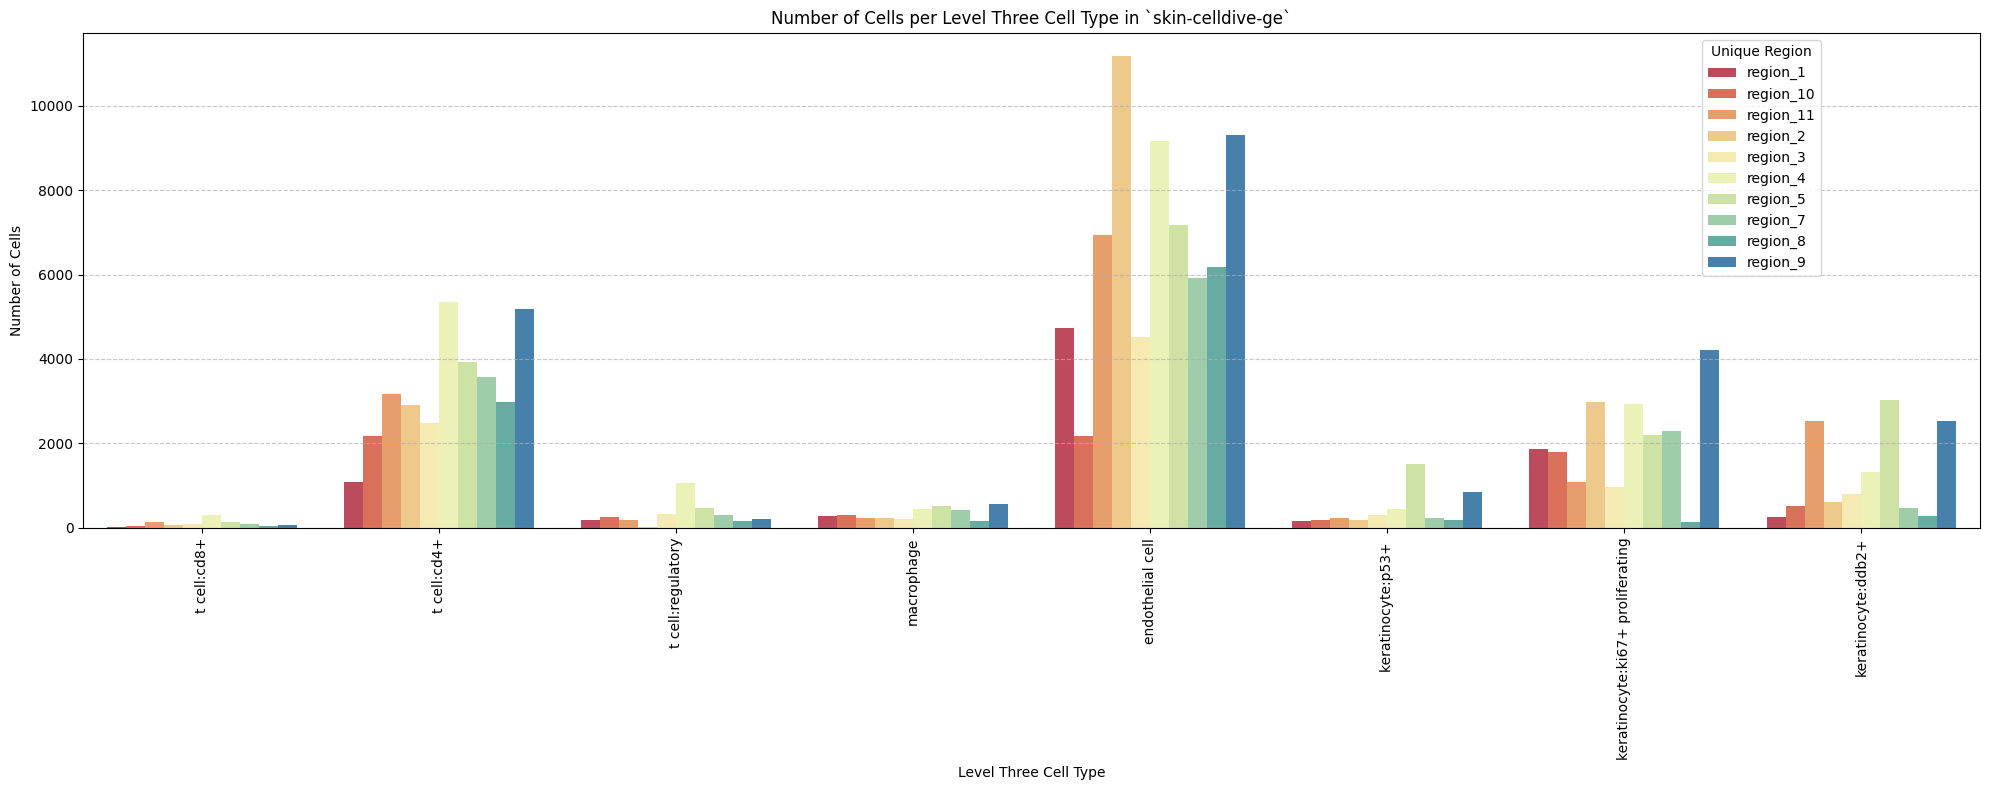

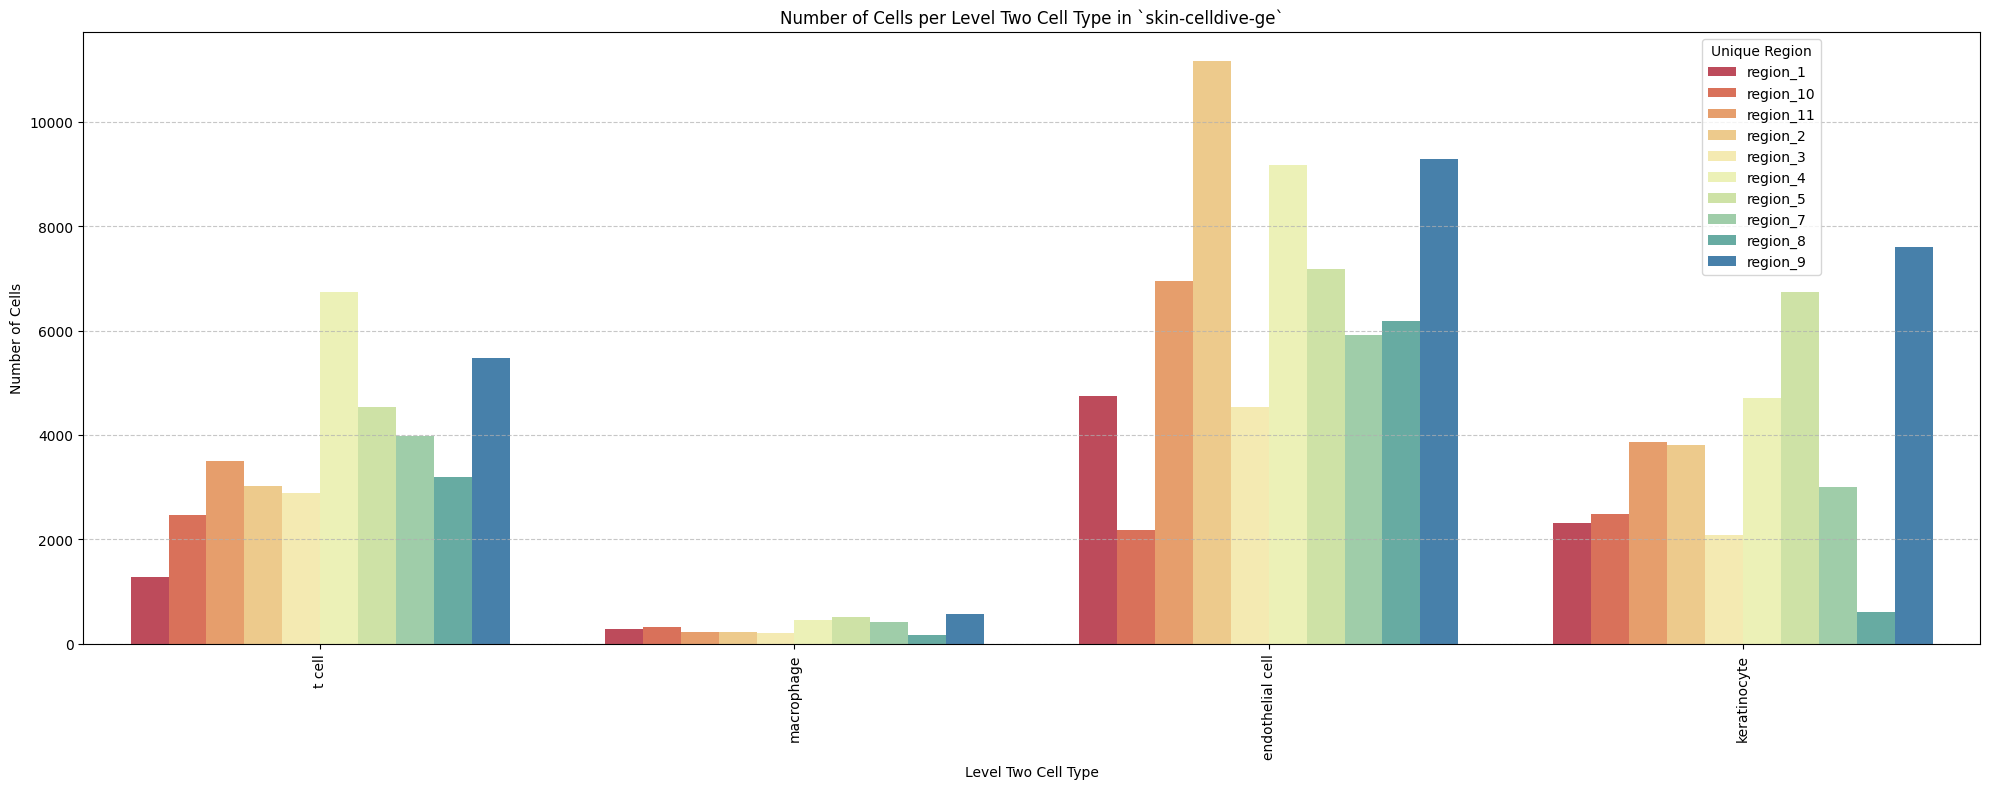

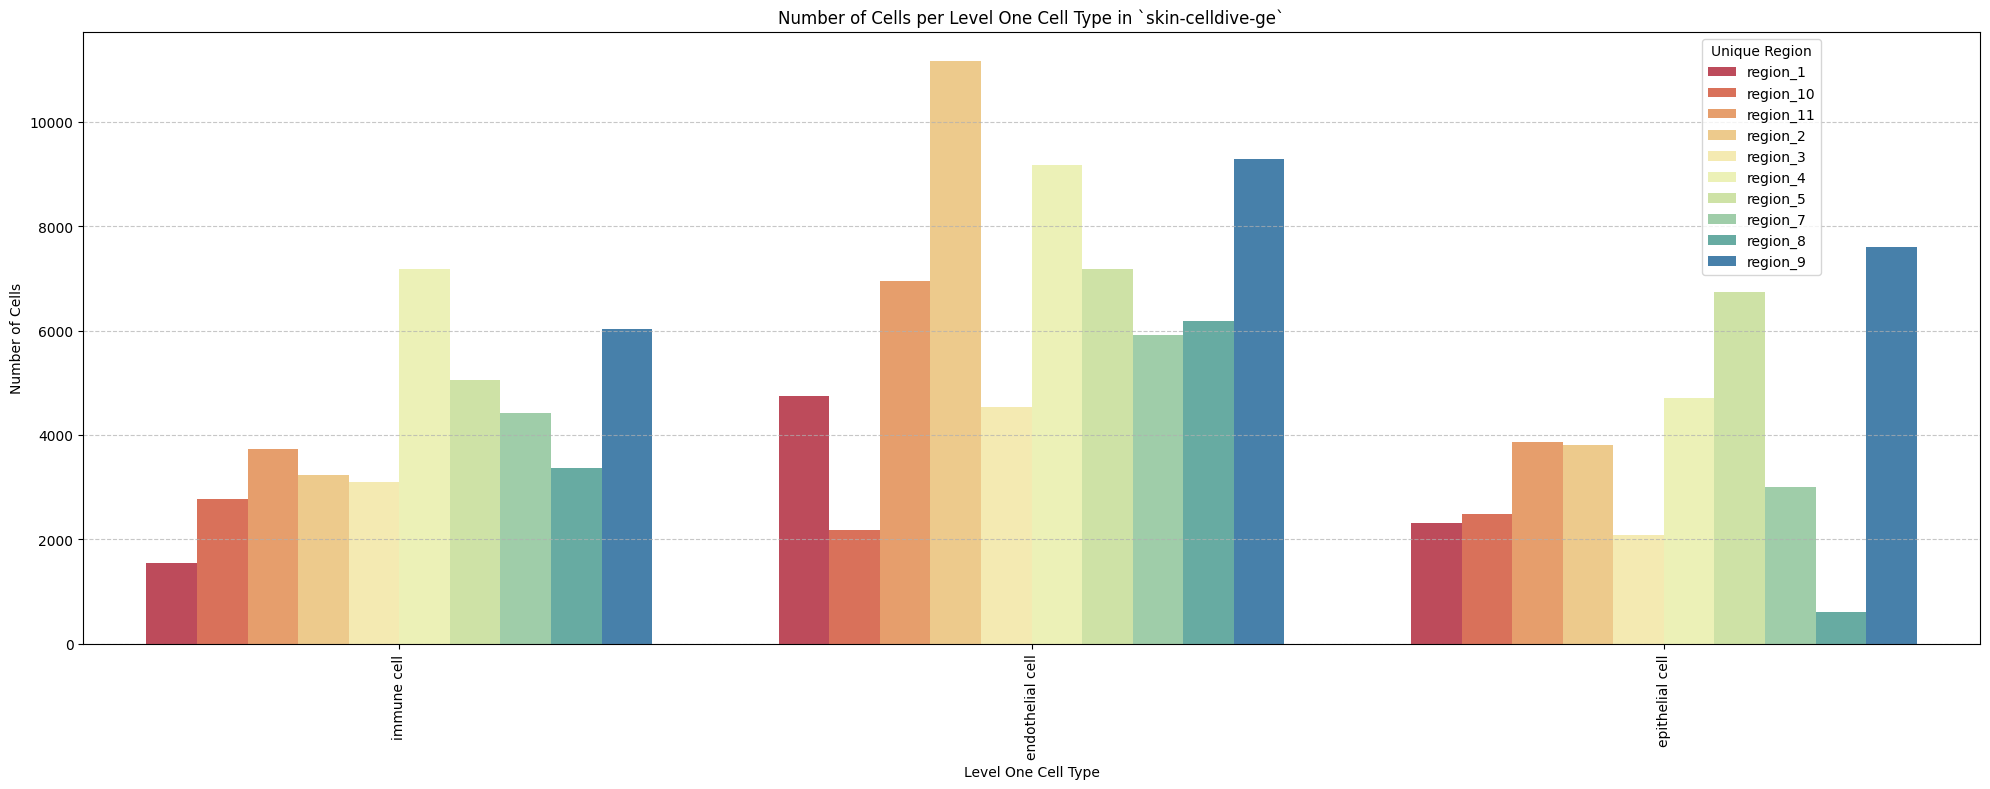

In [21]:
# Plot number of cells per cell type in the same plot. Color by cell type and unique region. Output figure saved in existing `figures_output_dir`.
def plot_cells_per_celltype(df, type_field, output_dir):
    plt.figure(figsize=(20, 8))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    sns.countplot(data=df, x=type_field, palette='Spectral', hue='Unique Region')
    plt.title(f'Number of Cells per {type_field} in `{dataset_dir}`')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.legend(title='Unique Region', bbox_to_anchor=(0.85, 1), loc='upper left')
    plt.xlabel(type_field)

    # For numbers on y-axis, do not use scientific notation.
    plt.ticklabel_format(style='plain', axis='y')
    # Set y-axis label
    plt.ylabel('Number of Cells')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Show the plot
    plt.show()
    plt.close()
for type_field in type_field_list:
    plot_cells_per_celltype(df_all_nodes, type_field, os.path.join(basepath, figures_output_dir))

## Distance Analysis

In [22]:
# Get mean, median, minimum, maximum distance per unique region per anchor cell type.
df_distance_stats = df_all_edges_with_cell_types.groupby(['Unique Region', 'Anchor Cell Type', 'Anchor Cell Type Level']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
# Print the first few rows of the distance statistics DataFrame.
df_distance_stats

,Unique Region,Anchor Cell Type,Anchor Cell Type Level,mean_distance,median_distance,min_distance,max_distance
0,region_1,endothelial cell,Level One Cell Type,10.339891,9.627938,0.321218,35.549790
1,region_1,endothelial cell,Level Three Cell Type,10.339891,9.627938,0.321218,35.549790
2,region_1,endothelial cell,Level Two Cell Type,10.339891,9.627938,0.321218,35.549790
3,region_10,endothelial cell,Level One Cell Type,11.731047,10.629954,0.500000,52.648323
4,region_10,endothelial cell,Level Three Cell Type,11.731047,10.629954,0.500000,52.648323
5,region_10,endothelial cell,Level Two Cell Type,11.731047,10.629954,0.500000,52.648323
6,region_11,endothelial cell,Level One Cell Type,11.084870,9.023278,0.457433,61.572358
7,region_11,endothelial cell,Level Three Cell Type,11.084870,9.023278,0.457433,61.572358
8,region_11,endothelial cell,Level Two Cell Type,11.084870,9.023278,0.457433,61.572358
9,region_2,endothelial cell,Level One Cell Type,11.321866,8.963334,0.000000,63.424592


### Level One Cell Type Analysis

In [23]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level One Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level One Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,epithelial cell,region_1,10.942273,10.290975,0.725522,30.013880
1,epithelial cell,region_10,12.361319,11.790882,0.707107,30.695997
2,epithelial cell,region_11,10.196528,8.800049,0.500000,61.164532
3,epithelial cell,region_2,10.745935,9.035553,0.017000,59.438487
4,epithelial cell,region_3,10.267738,9.600986,0.756604,34.270687
5,epithelial cell,region_4,8.793482,8.015610,0.157318,41.847939
6,epithelial cell,region_5,15.737377,11.491433,0.443152,81.273438
7,epithelial cell,region_7,12.058310,11.410651,1.008021,37.367765
8,epithelial cell,region_8,9.839488,7.435609,1.840557,72.194326
9,epithelial cell,region_9,9.762396,9.006318,1.027511,82.574584


In [24]:
# Get top five and bottom five cell types with respect to mean distance in each unique region separately.
def get_top_bottom_cell_types_by_mean(df, cell_type_level, unique_region, top_n=5):
    # Filter the DataFrame for the specified unique region and cell type level
    df_filtered = df[df['Unique Region'] == unique_region]

    # Group by the specified cell type level and calculate mean distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(mean_distance=('Distance', 'mean')).reset_index()
    
    # Sort by mean distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='mean_distance', ascending=False)
    
    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types

# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in region_1:
  Level One Cell Type  mean_distance
0     epithelial cell      10.942273
1         immune cell       9.444458

Bottom 5 cell types in region_1:
  Level One Cell Type  mean_distance
0     epithelial cell      10.942273
1         immune cell       9.444458

Top 5 cell types in region_10:
  Level One Cell Type  mean_distance
0     epithelial cell      12.361319
1         immune cell      11.165366

Bottom 5 cell types in region_10:
  Level One Cell Type  mean_distance
0     epithelial cell      12.361319
1         immune cell      11.165366

Top 5 cell types in region_11:
  Level One Cell Type  mean_distance
1         immune cell      12.004633
0     epithelial cell      10.196528

Bottom 5 cell types in region_11:
  Level One Cell Type  mean_distance
1         immune cell      12.004633
0     epithelial cell      10.196528

Top 5 cell types in region_2:
  Level One Cell Type  mean_distance
1         immune cell      11.998585
0     epithelial cell      10.

In [25]:
# Get top five and bottom five cell types with respect to median distance in each unique region separately.
def get_top_bottom_cell_types_by_median(df, cell_type_level, unique_region, top_n=5):
    # Filter the DataFrame for the specified unique region and cell type level
    df_filtered = df[df['Unique Region'] == unique_region]

    # Group by the specified cell type level and calculate median distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(median_distance=('Distance', 'median')).reset_index()

    # Sort by median distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='median_distance', ascending=False)

    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types

# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in region_1:
  Level One Cell Type  median_distance
0     epithelial cell        10.290975
1         immune cell         8.216023

Bottom 5 cell types in region_1:
  Level One Cell Type  median_distance
0     epithelial cell        10.290975
1         immune cell         8.216023

Top 5 cell types in region_10:
  Level One Cell Type  median_distance
0     epithelial cell        11.790882
1         immune cell         9.002613

Bottom 5 cell types in region_10:
  Level One Cell Type  median_distance
0     epithelial cell        11.790882
1         immune cell         9.002613

Top 5 cell types in region_11:
  Level One Cell Type  median_distance
1         immune cell         9.287078
0     epithelial cell         8.800049

Bottom 5 cell types in region_11:
  Level One Cell Type  median_distance
1         immune cell         9.287078
0     epithelial cell         8.800049

Top 5 cell types in region_2:
  Level One Cell Type  median_distance
0     epithelial cell        

In [26]:
# Calculate regional variability
def calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level):
    """    Calculate regional variability for distances in the given DataFrame.
    """
    regional_variability = df_all_edges_with_cell_type_level.groupby('Unique Region')['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    regional_variability['CV (%)'] = (regional_variability['std'] / regional_variability['mean'] * 100).round(1)

    print("\nRegional Variability Analysis:")
    print("Mean: Average distance in each region")
    print("Std: Standard deviation of distances")
    print("CV: Coefficient of Variation (std/mean * 100%)")
    print(regional_variability)

    # Calculate variability for each cell type
    cell_type_variability = df_all_edges_with_cell_type_level.groupby(cell_type_level)['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    cell_type_variability['CV (%)'] = (cell_type_variability['std'] / cell_type_variability['mean'] * 100).round(1)

    print("\nCell Type Variability Analysis (sorted by CV):")
    print(cell_type_variability.sort_values('CV (%)', ascending=False))

calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                mean    std  CV (%)
Unique Region                      
region_1       10.34   5.68    54.9
region_10      11.73   6.71    57.2
region_11      11.08   8.25    74.5
region_2       11.32   8.83    78.0
region_3        9.74   7.16    73.5
region_4        8.40   5.68    67.6
region_5       13.18  13.21   100.2
region_7       11.39   8.19    71.9
region_8       14.01  14.89   106.3
region_9        8.92   5.78    64.8

Cell Type Variability Analysis (sorted by CV):
                      mean   std  CV (%)
Level One Cell Type                     
immune cell          10.17  9.66    95.0
epithelial cell      11.33  8.04    71.0


In [27]:
# Define the standard region sequence for plots (Get all unique values in Unique Region column as a list.)
regions = df_all_edges_with_cell_types['Unique Region'].unique().tolist()

# Custom sort to handle region_X format
def region_sort_key(region_name):
    # Extract the number after 'region_'
    number = int(region_name.split('_')[1])
    return number

regions = sorted(regions, key=region_sort_key)
print("\nRegions in the data:")
print(regions)


Regions in the data:
['region_1', 'region_2', 'region_3', 'region_4', 'region_5', 'region_7', 'region_8', 'region_9', 'region_10', 'region_11']


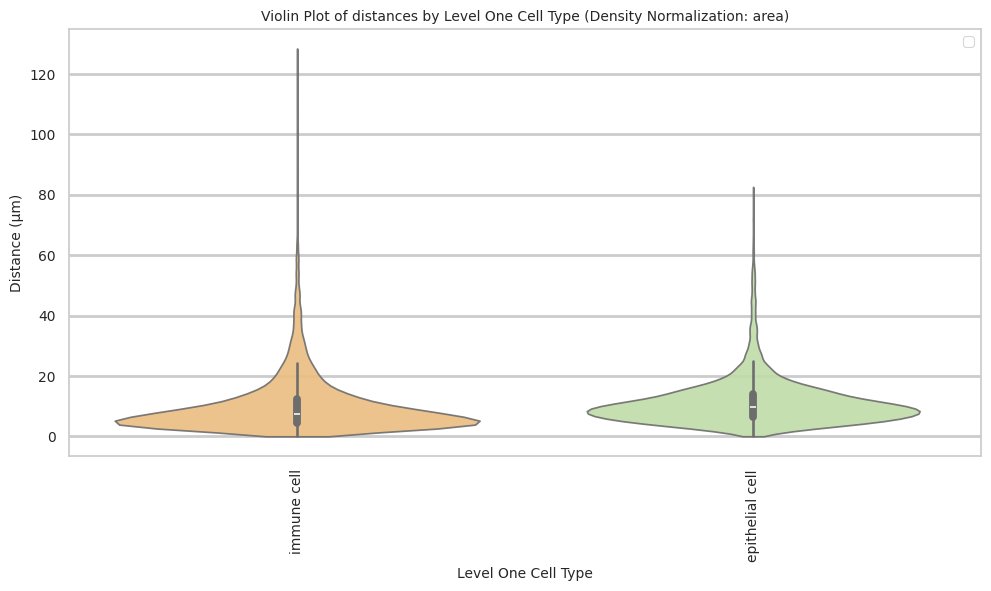

In [28]:
    # Generate Violin Plot
def plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm='area'):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 2})
    plt.figure(figsize=(10, 6))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path

    sns.violinplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y="Distance", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=False, palette='Spectral', alpha=.9)

    sns.set_theme(style="whitegrid")
    sns.set_context("paper")


    font_size = 10
    plt.legend(fontsize=font_size)

    plt.title(f'Violin Plot of distances by {cell_type_level} (Density Normalization: {density_norm})', fontsize=font_size)

    plt.xlabel(f'{cell_type_level}', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)

    # Increase font size for all text in the figure
    plt.xticks(fontsize=font_size)
    plt.xticks(rotation=90)
    plt.yticks(fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{cell_type_level}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{cell_type_level}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.show()

plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

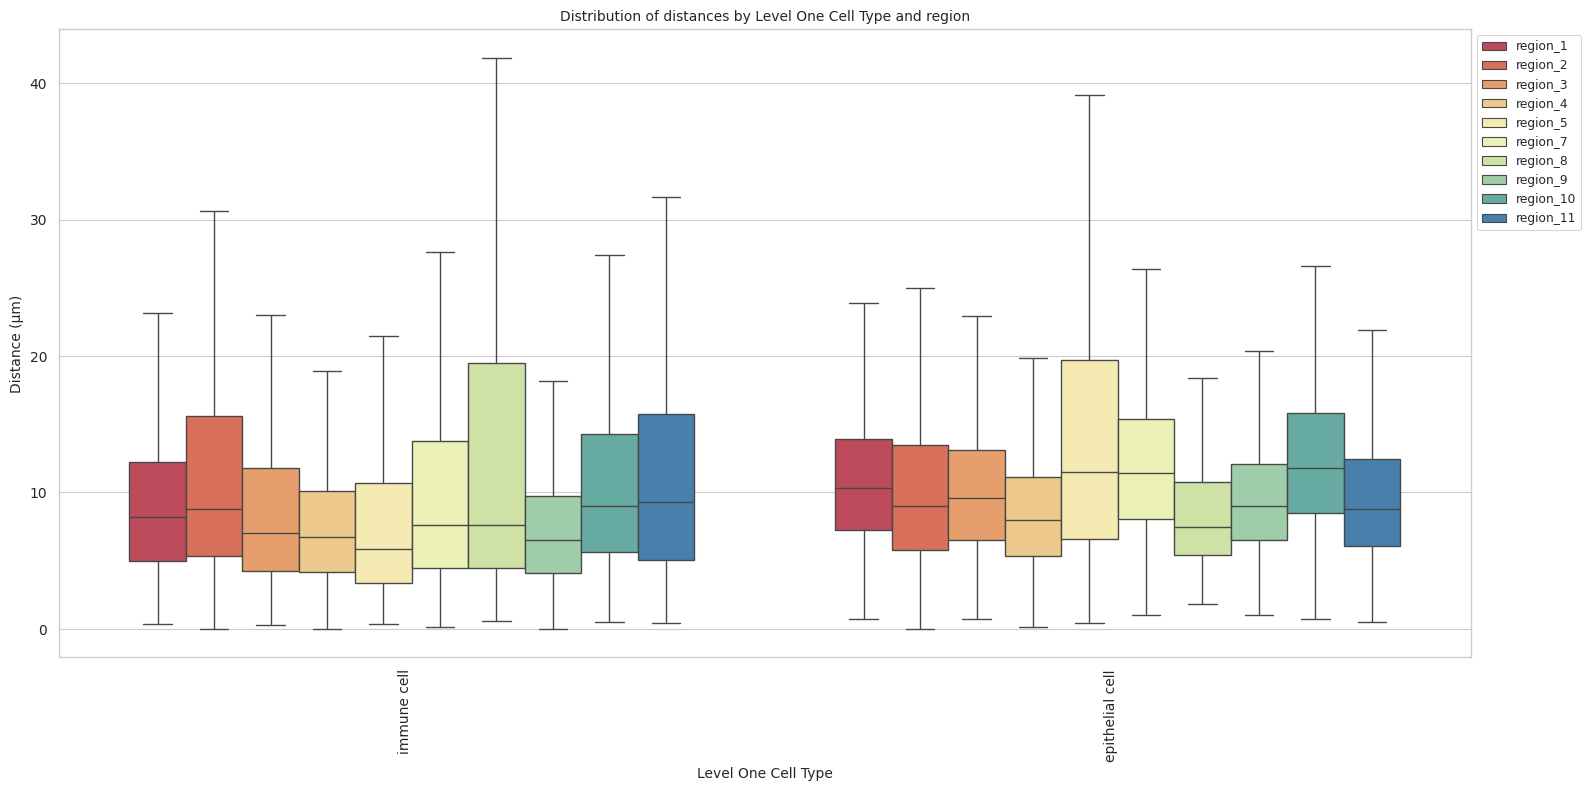

In [29]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    plt.figure(figsize=(16, 8))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    # Create categorical type with only the regions that exist in the data
    available_regions = [r for r in regions if r in df_all_edges_with_cell_type_level['Unique Region'].unique()]
    df_all_edges_with_cell_type_level['Unique Region'] = pd.Categorical(
        df_all_edges_with_cell_type_level['Unique Region'],
        categories=available_regions,
        ordered=True
    )

    # Make box plot.
    sns.boxplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y='Distance', hue='Unique Region', showfliers=False, palette='Spectral') # viridis or Spectral palette for better color distinction
    font_size = 10
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.title(f'Distribution of distances by {cell_type_level} and region', fontsize=font_size)
    plt.xlabel(f'{cell_type_level}', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

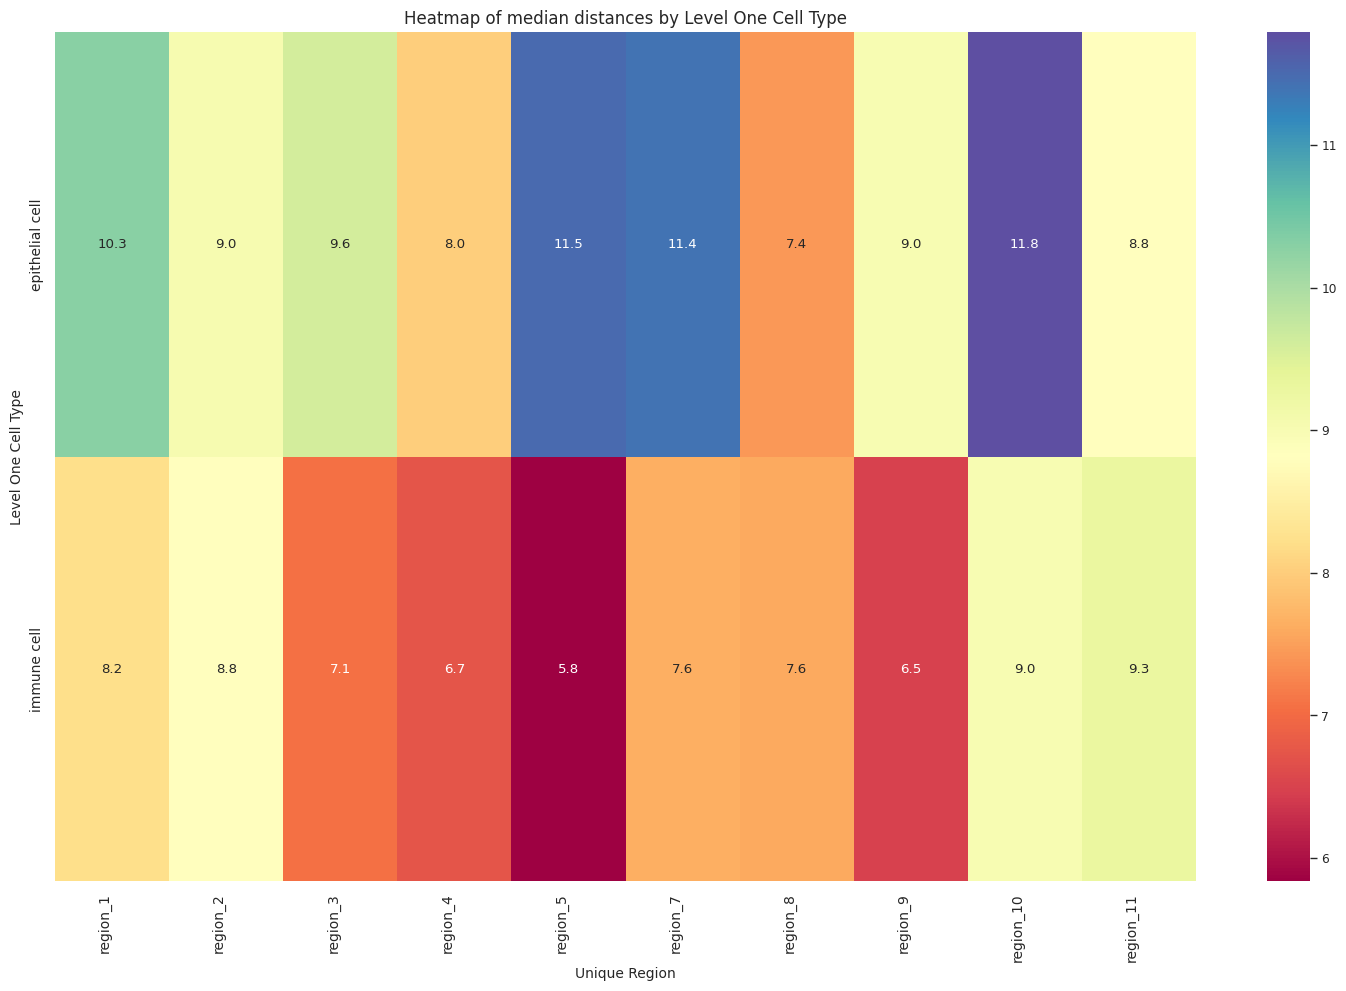

In [30]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    pivot_data = df_all_edges_with_cell_type_level.pivot_table(
    values='Distance',
    index=cell_type_level,
    columns='Unique Region',
    aggfunc='median'
    )

    plt.figure(figsize=(15, 10))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='Spectral')
    plt.title(f'Heatmap of median distances by {cell_type_level}', fontsize=12)

    font_size = 10
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    plt.yticks(fontsize=font_size)

    plt.xlabel('Unique Region', fontsize=font_size)
    plt.ylabel(f'{cell_type_level}', fontsize=font_size)
    
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

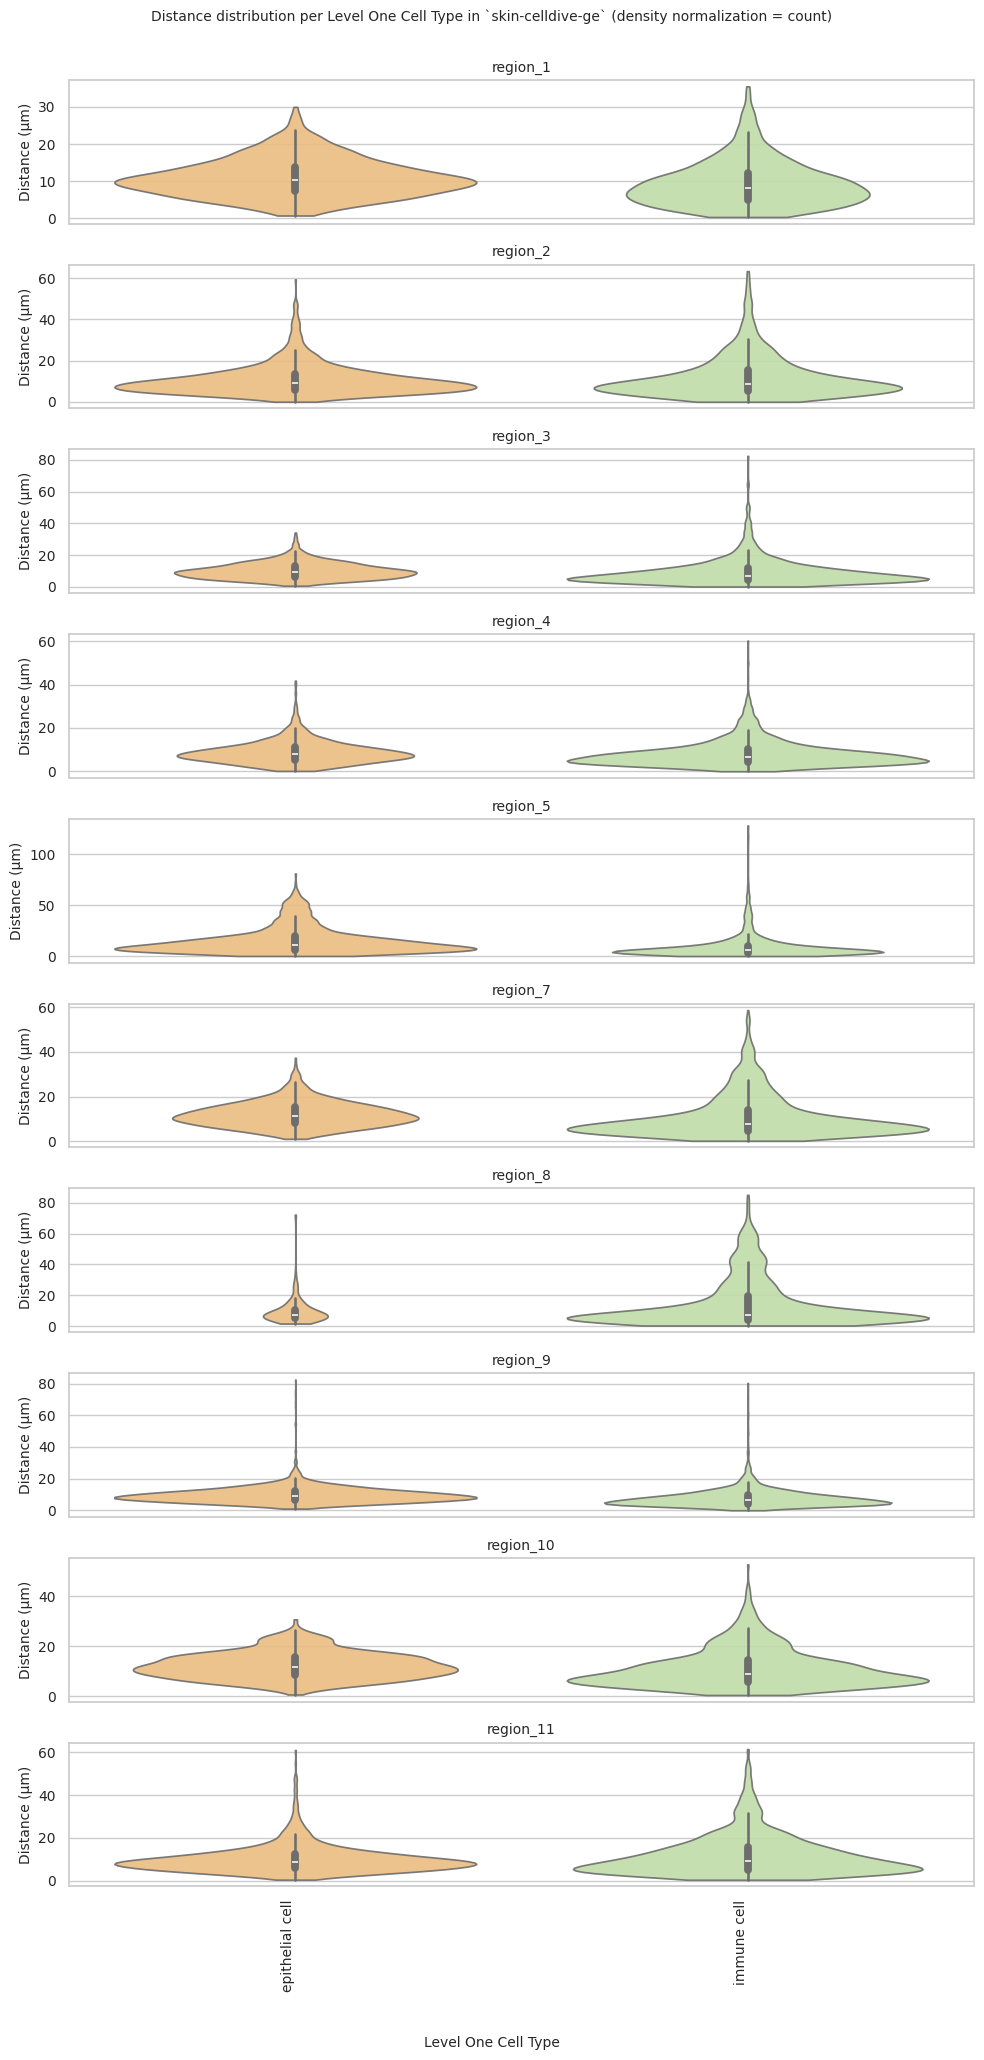

In [31]:
# Generate Violin Plot per unique region.
def plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm="area"):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 1})
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    font_size = 10
    fig, axs = plt.subplots(10, 1, figsize=(10, 20)) # Adjusted figsize for horizontal layout
    fig.suptitle(f'Distance distribution per {cell_type_level} in `{dataset_dir}` (density normalization = {density_norm})', fontsize=font_size, y=1)

    # Keep the sequence of Cell Types consistent across plots.
    cell_types = sorted(df_all_edges_with_cell_type_level[cell_type_level].unique())

    # Create a color palette based on the number of unique classes
    color_palette = sns.color_palette("Spectral", n_colors=len(cell_types))

    # Create a dictionary mapping class to color
    class_color_dict = dict(zip(cell_types, color_palette))

    for i, region in enumerate(regions):
        data_reg = df_all_edges_with_cell_type_level[df_all_edges_with_cell_type_level['Unique Region'] == region]
        sns.violinplot(data=data_reg, x=cell_type_level, y="Distance", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=False, palette=class_color_dict, alpha=.9, ax=axs[i], hue=cell_type_level, legend=False, order=cell_types, fill=True)
        axs[i].set_title(region, fontsize=font_size)
        axs[i].set_xlabel('', fontsize=font_size)
        axs[i].set_ylabel('Distance (\u03bcm)', fontsize=font_size)
        # axs[i].tick_params(axis='x', labelrotation=90, labelsize=font_size)
        # only show xtick labels for the last subplot
        if i < len(regions) - 1:
            axs[i].set_xticklabels([])
        else:
            axs[i].set_xticklabels(cell_types, fontsize=font_size, rotation=90, ha='right')
        # axs[i].set_ylim(0, data_reg['Distance'].max() * 1.1)  # Set y-limits to be consistent across all plots
        axs[i].tick_params(axis='both', labelsize=font_size)

    # Use fig.text for precise label positioning
    fig.figure.text(0.5, -0.02, f'{cell_type_level}', ha='center', va='bottom', fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    
    plt.show()

plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # density_norm="count" or "area" can be used based on preference.

### Level Two Cell Type Analysis

In [32]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level Two Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Two Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,keratinocyte,region_1,10.942273,10.290975,0.725522,30.013880
1,keratinocyte,region_10,12.361319,11.790882,0.707107,30.695997
2,keratinocyte,region_11,10.196528,8.800049,0.500000,61.164532
3,keratinocyte,region_2,10.745935,9.035553,0.017000,59.438487
4,keratinocyte,region_3,10.267738,9.600986,0.756604,34.270687
5,keratinocyte,region_4,8.793482,8.015610,0.157318,41.847939
6,keratinocyte,region_5,15.737377,11.491433,0.443152,81.273438
7,keratinocyte,region_7,12.058310,11.410651,1.008021,37.367765
8,keratinocyte,region_8,9.839488,7.435609,1.840557,72.194326
9,keratinocyte,region_9,9.762396,9.006318,1.027511,82.574584


In [33]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in region_1:
  Level Two Cell Type  mean_distance
1          macrophage      12.153733
0        keratinocyte      10.942273
2              t cell       8.851605

Bottom 5 cell types in region_1:
  Level Two Cell Type  mean_distance
1          macrophage      12.153733
0        keratinocyte      10.942273
2              t cell       8.851605

Top 5 cell types in region_10:
  Level Two Cell Type  mean_distance
1          macrophage      13.729961
0        keratinocyte      12.361319
2              t cell      10.834249

Bottom 5 cell types in region_10:
  Level Two Cell Type  mean_distance
1          macrophage      13.729961
0        keratinocyte      12.361319
2              t cell      10.834249

Top 5 cell types in region_11:
  Level Two Cell Type  mean_distance
1          macrophage      13.436212
2              t cell      11.911482
0        keratinocyte      10.196528

Bottom 5 cell types in region_11:
  Level Two Cell Type  mean_distance
1          macrophage   

In [34]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])



Top 5 cell types in region_1:
  Level Two Cell Type  median_distance
1          macrophage        11.313708
0        keratinocyte        10.290975
2              t cell         7.679430

Bottom 5 cell types in region_1:
  Level Two Cell Type  median_distance
1          macrophage        11.313708
0        keratinocyte        10.290975
2              t cell         7.679430

Top 5 cell types in region_10:
  Level Two Cell Type  median_distance
1          macrophage        11.883401
0        keratinocyte        11.790882
2              t cell         8.697919

Bottom 5 cell types in region_10:
  Level Two Cell Type  median_distance
1          macrophage        11.883401
0        keratinocyte        11.790882
2              t cell         8.697919

Top 5 cell types in region_11:
  Level Two Cell Type  median_distance
1          macrophage        13.851233
2              t cell         9.146366
0        keratinocyte         8.800049

Bottom 5 cell types in region_11:
  Level Two Cell Type

In [35]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                mean    std  CV (%)
Unique Region                      
region_1       10.34   5.68    54.9
region_10      11.73   6.71    57.2
region_11      11.08   8.25    74.5
region_2       11.32   8.83    78.0
region_3        9.74   7.16    73.5
region_4        8.40   5.68    67.6
region_5       13.18  13.21   100.2
region_7       11.39   8.19    71.9
region_8       14.01  14.89   106.3
region_9        8.92   5.78    64.8

Cell Type Variability Analysis (sorted by CV):
                      mean    std  CV (%)
Level Two Cell Type                      
macrophage           13.14  13.03    99.2
t cell                9.90   9.24    93.3
keratinocyte         11.33   8.04    71.0


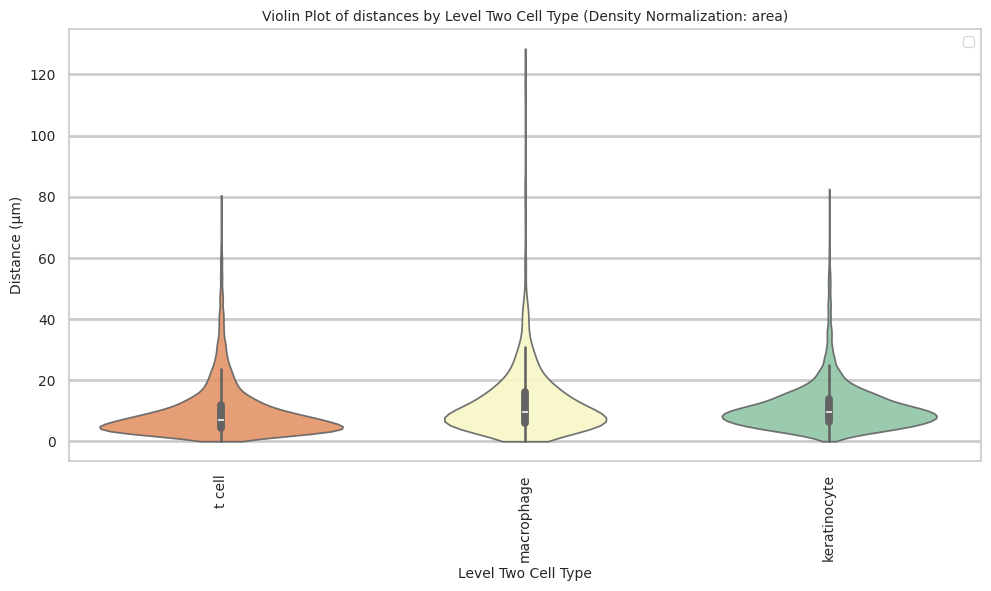

In [36]:
plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

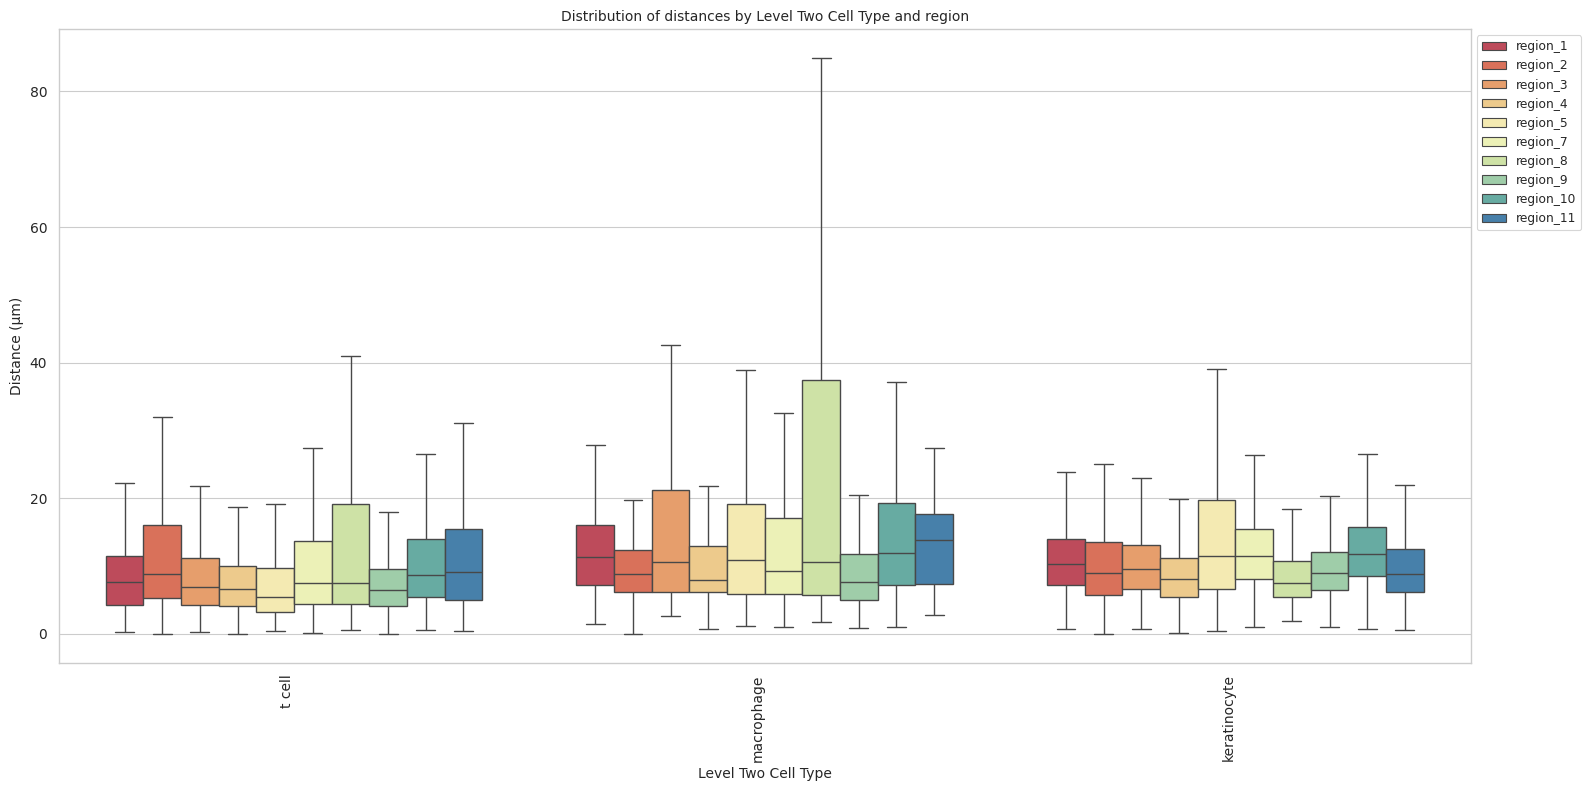

In [37]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

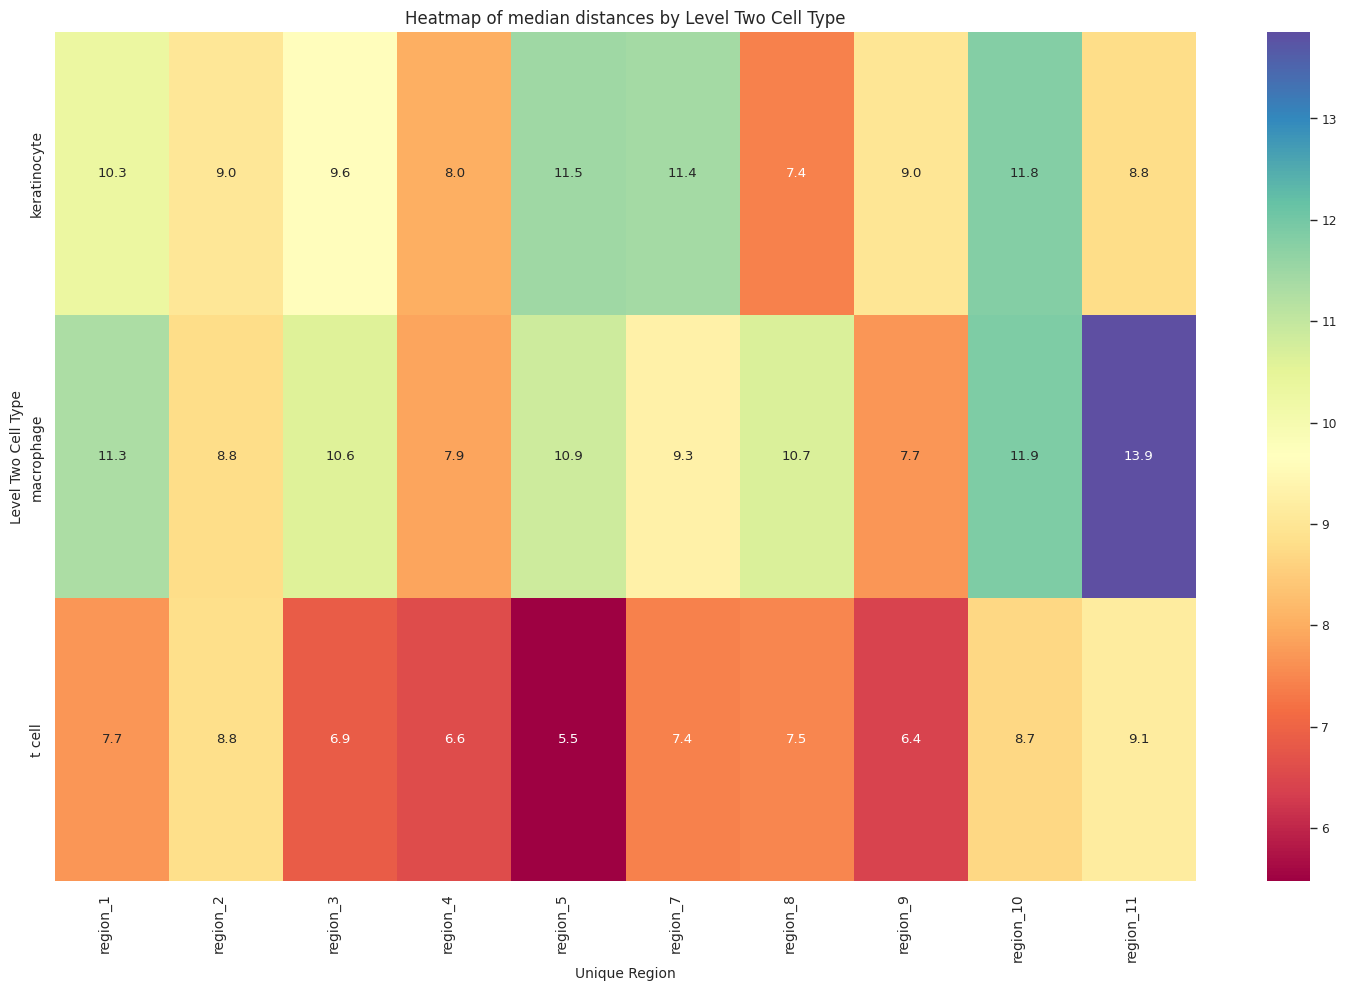

In [38]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

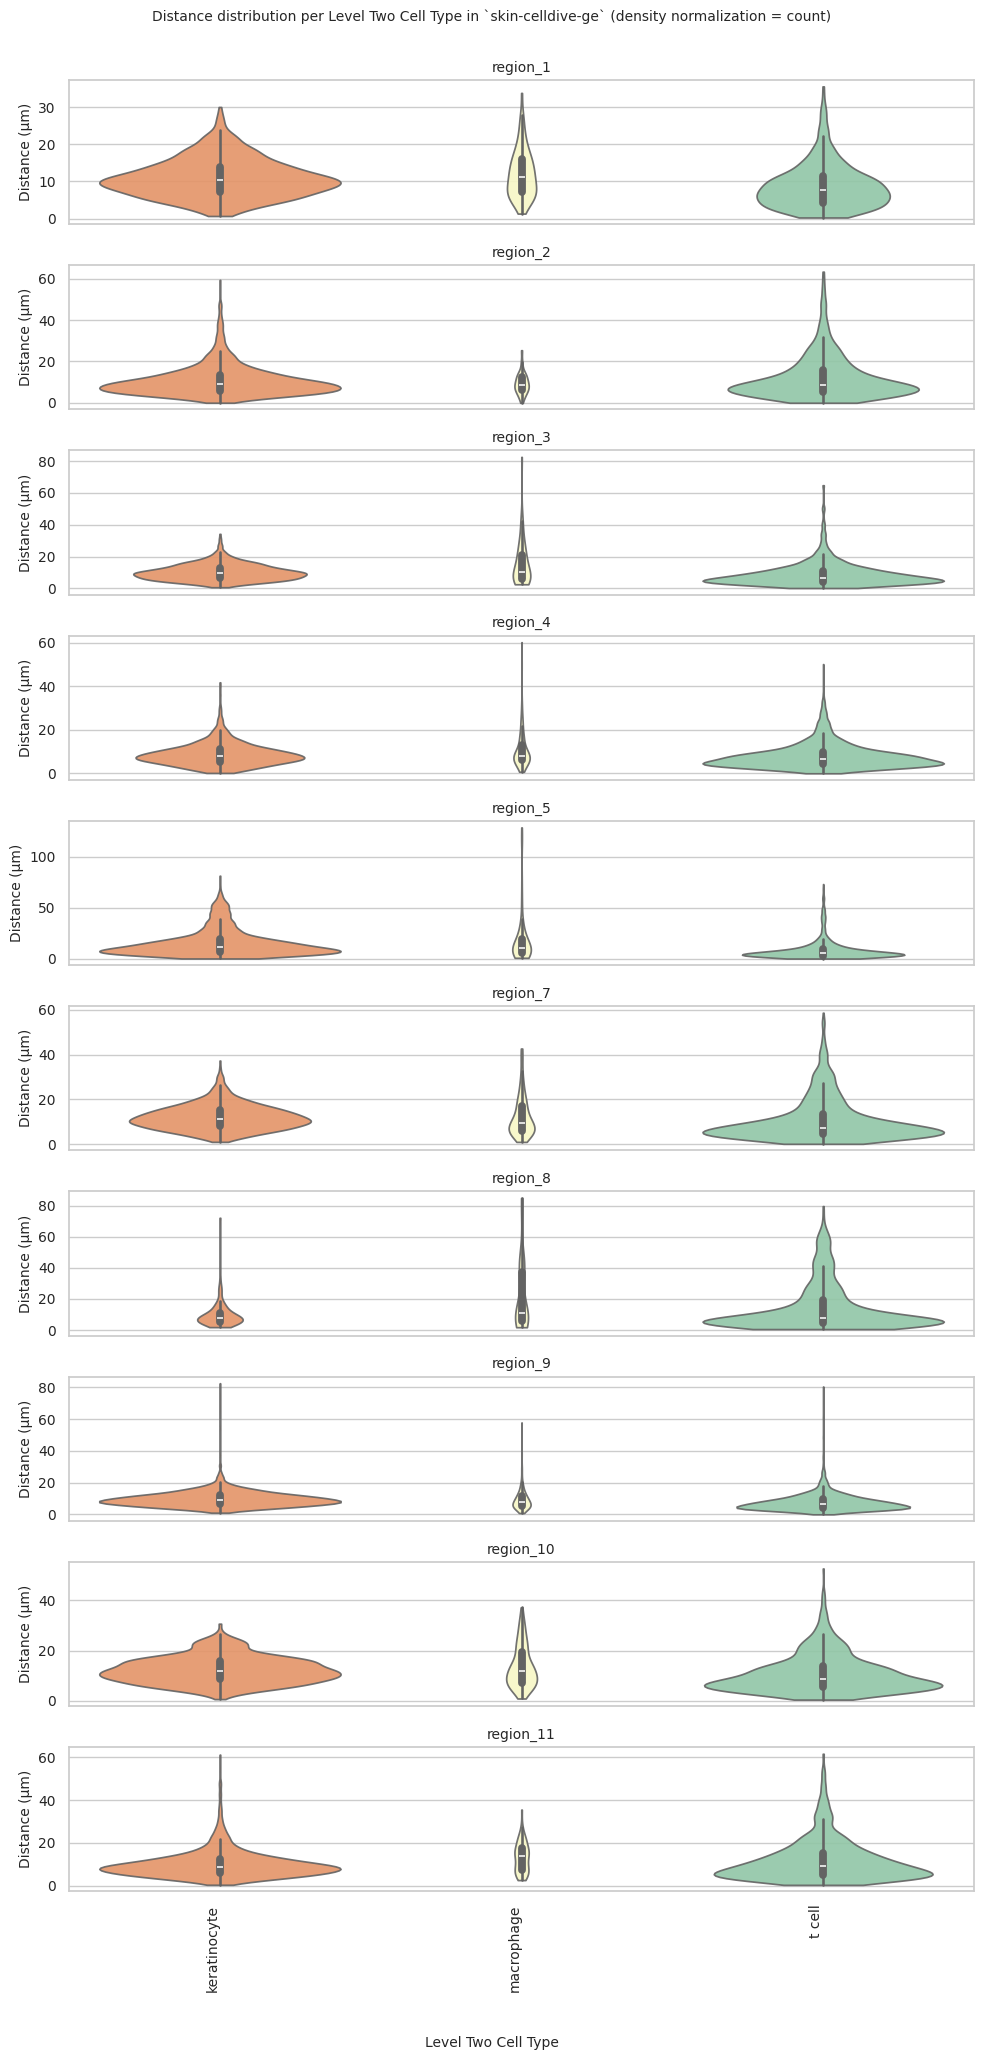

In [39]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count" or "area" based on preference.

### Level Three Cell Type Analysis

In [40]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level Three Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Three Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,keratinocyte:ddb2+,region_1,10.886045,10.001243,1.255159,26.832704
1,keratinocyte:ddb2+,region_10,11.629010,11.056795,0.707107,27.110916
2,keratinocyte:ddb2+,region_11,10.904713,9.290249,0.500000,61.164532
3,keratinocyte:ddb2+,region_2,9.904681,8.860067,0.225471,40.017169
4,keratinocyte:ddb2+,region_3,9.982988,9.486833,1.085756,27.698531
5,keratinocyte:ddb2+,region_4,8.325188,7.424621,0.236174,39.442424
6,keratinocyte:ddb2+,region_5,16.566213,12.103718,0.515830,81.273438
7,keratinocyte:ddb2+,region_7,11.048429,10.779681,1.704540,29.504403
8,keratinocyte:ddb2+,region_8,9.996099,7.452943,2.340808,72.081273
9,keratinocyte:ddb2+,region_9,9.230936,8.503737,1.072485,65.549106


In [41]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in region_1:
              Level Three Cell Type  mean_distance
3                        macrophage      12.153733
1  keratinocyte:ki67+ proliferating      11.107341
0                keratinocyte:ddb2+      10.886045
2                keratinocyte:p53+        9.158517
4                       t cell:cd4+       8.869032

Bottom 5 cell types in region_1:
  Level Three Cell Type  mean_distance
0    keratinocyte:ddb2+      10.886045
2    keratinocyte:p53+        9.158517
4           t cell:cd4+       8.869032
6     t cell:regulatory       8.787226
5           t cell:cd8+       8.244478

Top 5 cell types in region_10:
              Level Three Cell Type  mean_distance
3                        macrophage      13.729961
1  keratinocyte:ki67+ proliferating      12.695907
0                keratinocyte:ddb2+      11.629010
6                 t cell:regulatory      11.312539
2                keratinocyte:p53+       11.131305

Bottom 5 cell types in region_10:
  Level Three Cell Typ

In [42]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in region_1:
              Level Three Cell Type  median_distance
3                        macrophage        11.313708
1  keratinocyte:ki67+ proliferating        10.514693
0                keratinocyte:ddb2+        10.001243
2                keratinocyte:p53+          8.938114
5                       t cell:cd8+         8.892451

Bottom 5 cell types in region_1:
  Level Three Cell Type  median_distance
0    keratinocyte:ddb2+        10.001243
2    keratinocyte:p53+          8.938114
5           t cell:cd8+         8.892451
4           t cell:cd4+         7.679430
6     t cell:regulatory         7.174825

Top 5 cell types in region_10:
              Level Three Cell Type  median_distance
1  keratinocyte:ki67+ proliferating        12.298586
3                        macrophage        11.883401
0                keratinocyte:ddb2+        11.056795
2                keratinocyte:p53+          9.739514
6                 t cell:regulatory         9.433981

Bottom 5 cell types 

In [43]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                mean    std  CV (%)
Unique Region                      
region_1       10.34   5.68    54.9
region_10      11.73   6.71    57.2
region_11      11.08   8.25    74.5
region_2       11.32   8.83    78.0
region_3        9.74   7.16    73.5
region_4        8.40   5.68    67.6
region_5       13.18  13.21   100.2
region_7       11.39   8.19    71.9
region_8       14.01  14.89   106.3
region_9        8.92   5.78    64.8

Cell Type Variability Analysis (sorted by CV):
                                   mean    std  CV (%)
Level Three Cell Type                                 
macrophage                        13.14  13.03    99.2
t cell:cd4+                       10.09   9.48    94.0
keratinocyte:p53+                 12.61  11.55    91.6
t cell:regulatory                  8.75   7.19    82.2
t cell:cd8+                        7

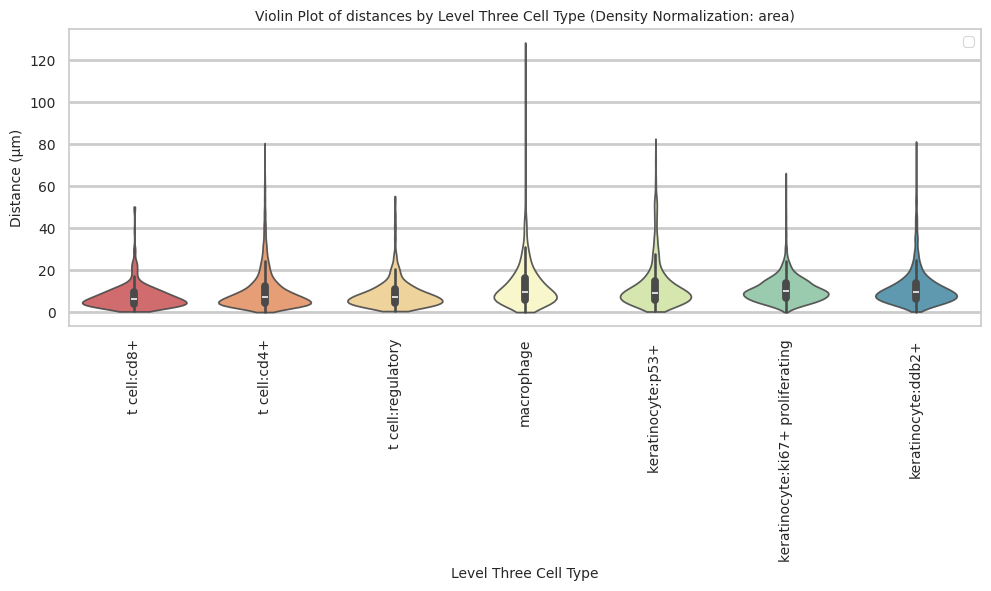

In [44]:
plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

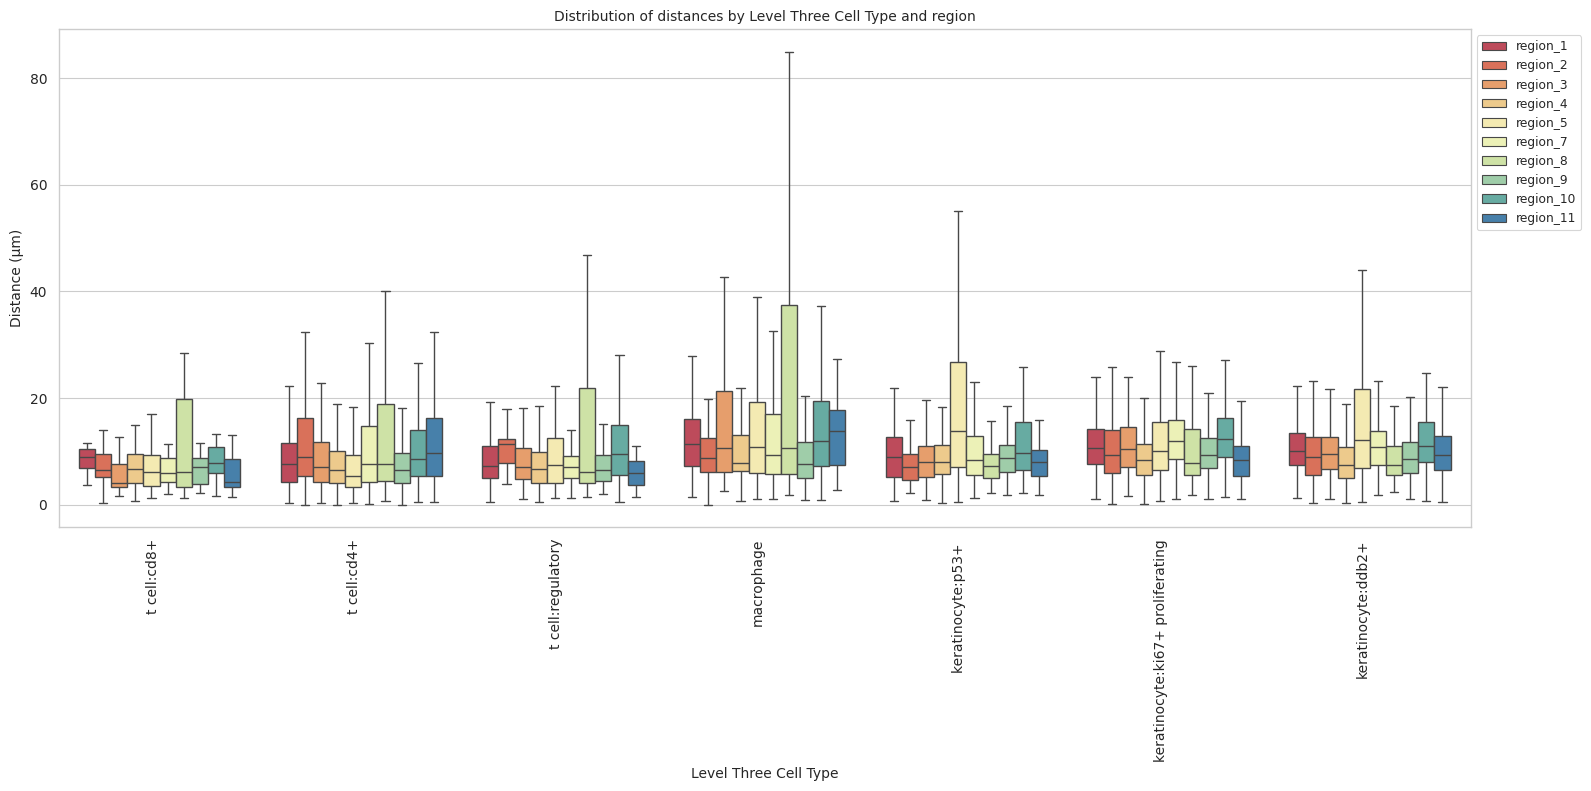

In [45]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

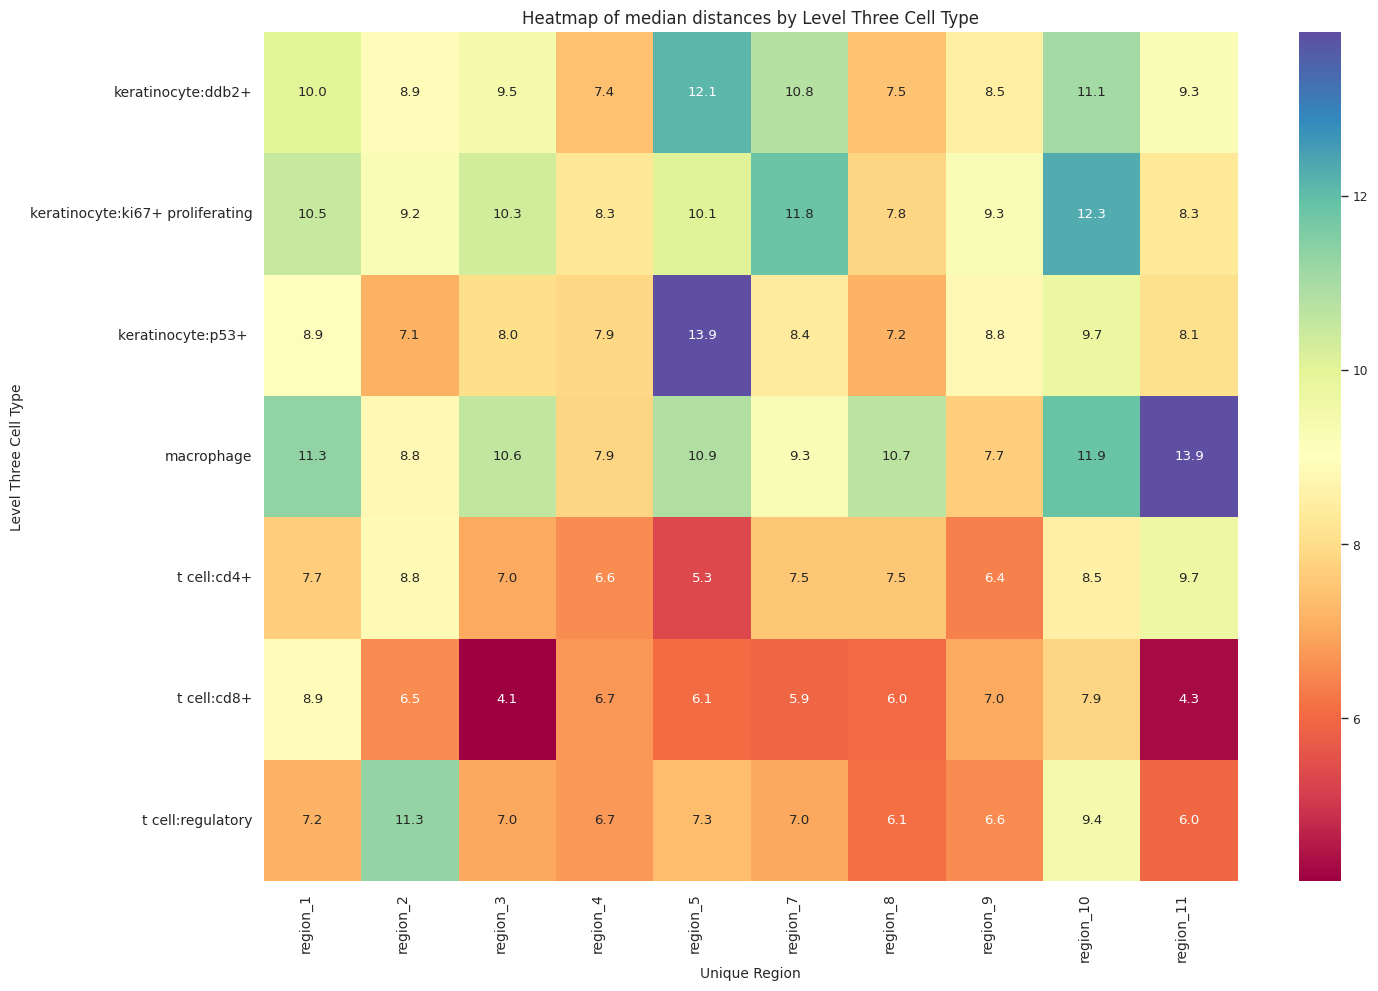

In [46]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

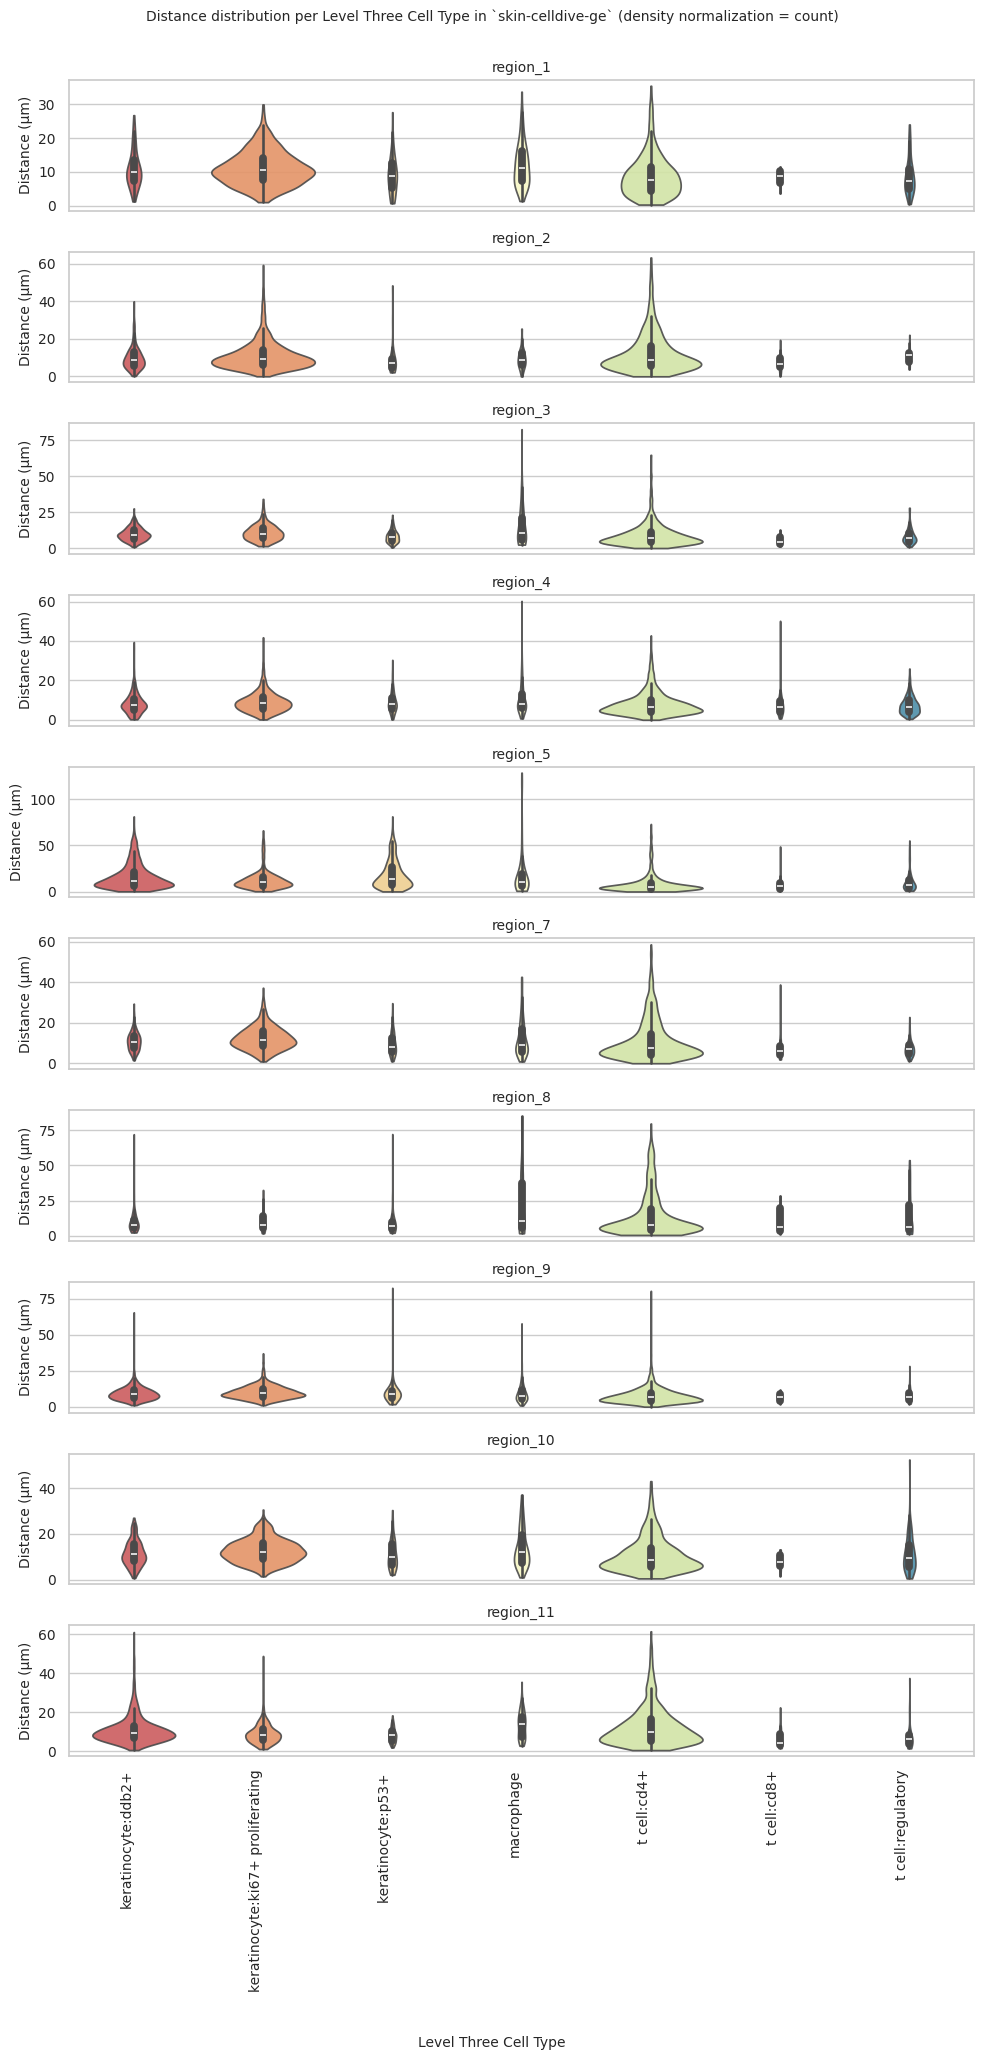

In [47]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count" or "area" based on preference.